### Wersja poc na samym numpy

Wielomiany legendre do 6 stopnia 

In [97]:
import numpy as np, matplotlib.pyplot as plt
np.random.seed(0)

deg = 5 # po testach wyszło mi najmniejsze mse dla dge = 5 ale i tak nie zadowalające

def legendre(u, deg=1):
    """
    Ortonormalne (na [0,1]) wielomiany Legendre’a przesunięte (shifted),
    ze współczynnikiem  √(2n+1).  Zwraca tablicę kształtu (..., deg+1),
    gdzie kolumna 0 to f₀(u)=1, kol. 1 to f₁(u) itd.
    """
    out = [np.ones_like(u)]                         # f0
    if deg >= 1:  # f1
        out.append(np.sqrt(3)*(2*u - 1))
    if deg >= 2:  # f2
        out.append(np.sqrt(5)*(6*u**2 - 6*u + 1))
    if deg >= 3:  # f3
        out.append(np.sqrt(7)*(20*u**3 - 30*u**2 + 12*u - 1))
    if deg >= 4:  # f4
        out.append(np.sqrt(9)*(70*u**4 - 140*u**3 + 90*u**2 - 20*u + 1))
    if deg >= 5:  # f5
        out.append(np.sqrt(11)*(252*u**5 - 630*u**4 + 560*u**3
                                - 210*u**2 + 30*u - 1))
    if deg >= 6:  # f6
        out.append(np.sqrt(13)*(924*u**6 - 2772*u**5 + 3150*u**4
                                - 1680*u**3 + 420*u**2 - 42*u + 1))
    return np.stack(out, axis=-1)


def quantile_norm(x):
    # Empiryczna CDF → (0,1)
    ranks = x.argsort().argsort() + 1
    return ranks / (len(x) + 1)

In [98]:
# Syntetyczne dane 2-D: dwa klastry na przekątnych
N = 1000
# te alfa beta dodałem aby testować bardziej złożone sytuacje szybciej
alpha = 0.1
beta = 0.5
x1 = np.concatenate([np.random.randn(N//2)*alpha - beta,
                     np.random.randn(N//2)*alpha + beta])
x2 = np.concatenate([np.random.randn(N//2)*alpha + beta,
                     np.random.randn(N//2)*alpha - beta])
X  = np.column_stack([x1, x2])


In [99]:
# #syntetyczne dane drugi case klasyczne two moons
# from sklearn.datasets import make_moons

# N = 4000
# X, _ = make_moons(n_samples=N, noise=0.01, random_state=0)
# x1, x2 = X[:, 0], X[:, 1]

# X  = np.column_stack([x1, x2])

In [100]:
u1, u2 = quantile_norm(X[:,0]), quantile_norm(X[:,1])
F1, F2 = legendre(u1, deg), legendre(u2, deg)    # (N,3)
a       = (F1.T @ F2) / N                        # (3,3) tensor
f  = legendre(np.array([u2]), deg)[0]
print("F1:", F1.shape, "F2:", F2.shape, "a:", a.shape)

F1: (1000, 6) F2: (1000, 6) a: (6, 6)


In [101]:
def E_u1_given_u2(u2_scalar, eps = 0.05):
    f = legendre(np.array([u2_scalar]), deg)[0]
    num   = sum(a[1,j]*f[j] for j in range(deg+1))
    denom = sum(a[0,j]*f[j] for j in range(deg+1))
    denom = max(denom, eps)
    return num/denom if denom > 1e-8 else np.nan

grid_u2  = np.linspace(0.05, 0.95, 100)
pred_u1  = np.array([E_u1_given_u2(v) for v in grid_u2])

print("f(u2=0.5) =", legendre(np.array([0.5]), deg)[0])
print("E_u1|u2=0.5 =", E_u1_given_u2(0.5))


f(u2=0.5) = [ 1.          0.         -1.11803399  0.          1.125       0.        ]
E_u1|u2=0.5 = 0.0048785124948817005


In [102]:
#helper: gęstość ρ(u1,u2) z clampem dodatniości ──
def density(u1_scalar, u2_scalar, eps=0.1):
    f1 = legendre(np.array([u1_scalar]), deg)[0]
    f2 = legendre(np.array([u2_scalar]), deg)[0]
    rho = (a * np.outer(f1, f2)).sum()
    return max(rho, eps)


In [103]:
#funkcja: przybliżona odwrotna CDF -> wracamy do "surowych" jednostek
def inv_cdf(u_val, raw):
    raw_sorted = np.sort(raw)
    idx        = np.clip((u_val*len(raw)).astype(int), 0, len(raw)-1)
    return raw_sorted[idx]

pred_raw = np.array([inv_cdf(p, X[:,0]) for p in pred_u1])
grid_raw = np.array([inv_cdf(g, X[:,1]) for g in grid_u2])

# Empiryczne średnie dla porównania
bins        = np.digitize(X[:,1], grid_raw)
true_means  = np.array([X[:,0][bins==i].mean() if (bins==i).sum()>0 else np.nan
                        for i in range(len(grid_raw))])


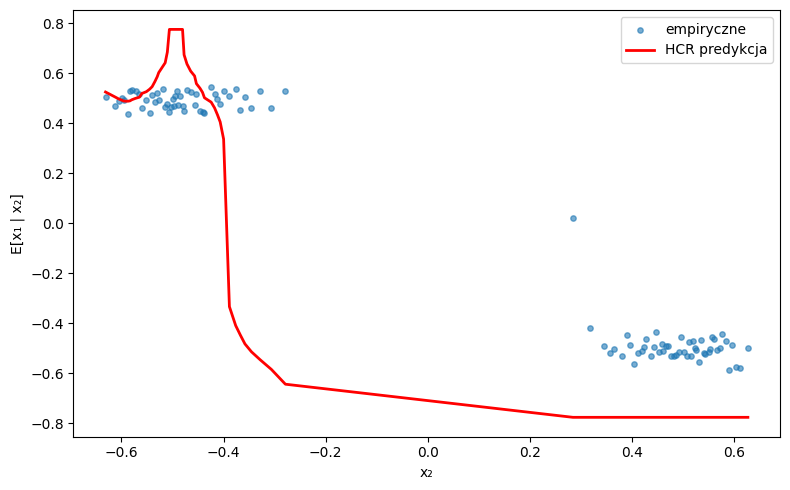

MSE warunkowych średnich ≈ 0.1341


In [104]:
plt.figure(figsize=(8,5))
plt.scatter(grid_raw, true_means, s=15, alpha=0.6, label='empiryczne')
plt.plot(grid_raw, pred_raw, color='red', lw=2, label='HCR predykcja')
plt.xlabel('x₂'); plt.ylabel('E[x₁ | x₂]')
plt.legend(); plt.tight_layout()
plt.show()

mse = np.nanmean((pred_raw - true_means)**2)
print("MSE warunkowych średnich ≈", round(float(mse), 4))


mse takie sobie biorąć pod uwagę prostote tego case`u
